## In this TD, we consider simple denoising algorithms, such as the ones considered in the lectures.

### We implement the four following methods: 

1. Use of a high-pass filter as a Gaussian and select experimentally the best standard deviation.
2. Use of hard-thresholding in the Fourier basis and select the best threshold.
3. Use of hard-thresholding in the Wavelet basis and select the best threshold.
4. Use of cycle-spinning and hard-thresholding in wavelet basis.
5. Replace hard with soft-thresholding in the previous experiments.

In [12]:
from __future__ import division
import scipy.misc
import numpy as np
import scipy as sp
import scipy.fftpack as ft
import imageio
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(633, 950, 3)
122.32328414916992 46.80025028089334 0.0
(512, 512)


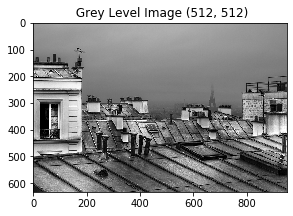

In [7]:
# load an image
import imageio as imio
colored_image = imio.imread('toits.jpg')
print(colored_image.shape)
n = colored_image.shape[0]-1
n = 512
image = np.sum(colored_image*[0.21, 0.72 ,0.07],axis=-1)[:n,200:200+n]

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.gray()
#cropped = image[n:n+64,n:n + 64]
plt.title(" Grey Level Image " + str(np.shape(image)))
cropped = image
plt.imshow(colored_image)
print(np.mean(cropped),np.std(cropped),(np.min(cropped)))
print(image.shape)
image0 = np.copy(image)

### Below are implemented the Gaussian noise and a version of the salt noise. The generative model is thus
\begin{equation}
I_{\text{observed}} = I_{true} + \text{GaussianNoise}\,.
\end{equation}
A denoiser is a map $\text{Denoise}$ that takes as input an image and output an image. It can be a linear map as in the case of the gaussian smoothing (first method you have to implement). Or, it can be a non-linear method as the case of hard-thresholding. 

In order to select a good value (of the standard deviation in the case of the gaussian denoiser, or the threshold for the hard-thresholding method) for the denoisers, we propose to use the SNR function implemented below. 

In [8]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

#signal divisé par bruit donc il faut qu'il soit grand

-0.0


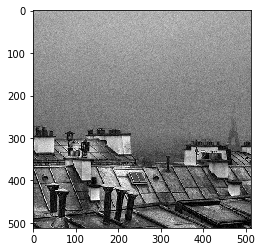

In [9]:
## Add some noise to the image
def clamp(x):
    temp =  255*(x>255) + x * (x<255) 
    return temp * (x>0)

def GaussianNoise(image,sigma):
    return clamp(image + sigma*np.random.randn(image.shape[0],image.shape[1]))

def SaltNoise(image,sigma):
    return clamp(image + sigma*(np.random.randn(image.shape[0],image.shape[1])>0))

sigma = 10.0
noisy_image  = clamp(image + sigma*np.random.randn(image.shape[0],image.shape[1]))
print(np.min(noisy_image))
plt.imshow(noisy_image)

### Below is implemented a convolution and the Gaussian filter.

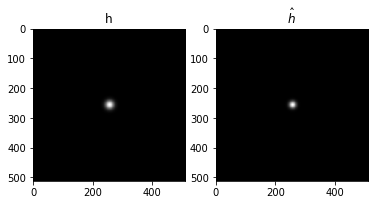

In [10]:
cconv1 = lambda a,b : real(ifft2(fft2(a)*fft2(b)))
normalize = lambda h : h/sum(h.flatten())
t = transpose( concatenate( (arange(0,n/2), arange(-n/2,0) ) ) )
[Y,X] = meshgrid(t, t)
hh = lambda mu: normalize(exp(-(X**2 + Y**2)/ (2*mu**2)))
mu = 10
plt.figure()
plt.subplot(1,2, 1)
plt.imshow(fftshift(hh(mu)))
title('h')
plt.subplot(1,2, 2)
plt.imshow(fftshift(real(fft2(hh(mu)))))
plt.title('$\hat h$');

### Here we implement the denoiser associated with this smoothing.
denoise = lambda x,mu : cconv1(hh(mu), x)

### Q1: Compare the results of this denoiser when varying the standard deviation of the filter. For that you can use the signal to noise ratio implemented above to compare the results. Vary the noise level and show the optimal denoised result.

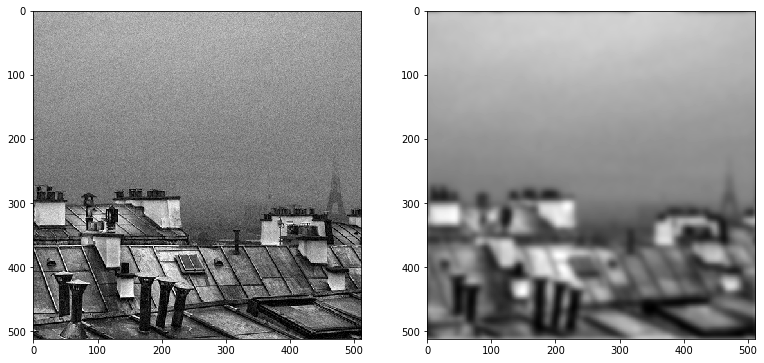

In [23]:
snrValues = []

aRange = np.arange(1,5,0.2)

for mu in aRange:
    denoised = denoise(noisy_image,mu)
    snrValues.append(round(snr(noisy_image, denoised),4))
    
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(noisy_image)
plt.subplot(132)
plt.imshow(denoised)

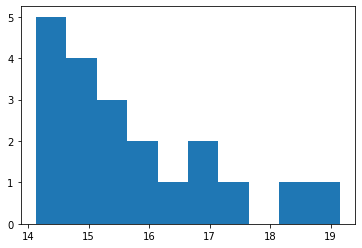

In [26]:
snrMin = np.array(snrValues).min()
snrMax = np.array(snrValues).max()
plt.hist(snrValues)
plt.show()

### Below is plotted the graph of the hard-thresholding function that you are going to apply to different descriptions of the image: 
1. In the Fourier basis,
2. In the wavelet basis.

### We also propose the soft-thresholding implemented below.

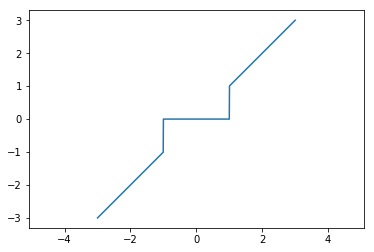

In [13]:
def HardThresholding(u,t):
    return u*(abs(u)>t)
alpha = linspace(-3,3,1000)
plot(alpha, HardThresholding(alpha,1))
axis('equal');

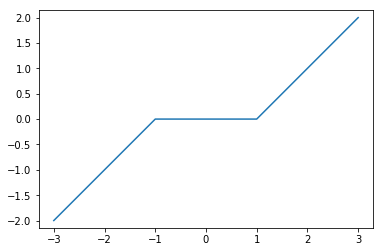

In [17]:
def SoftThresholding(u,t):
    return maximum(1-t/abs(u), 0)*u
alpha = linspace(-3,3,1000)
plot(alpha, SoftThresholding(alpha,1))
axis('equal');

### Q2: Implement the denoiser associated with the hard-thresholding method for the Fourier basis and show the best result.

### Below is implemented the wavelet transform using the Daubechies 4 filters and its inverse.

In [51]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h) ## make sure the filter has norm 1.
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))

def cconv(x, h, d):
    """
        Circular convolution along dimension d.
        len(h) must be  odd.
    """
    if d == 1:
        return np.transpose(cconv(np.transpose(x), h, 0))
    y = np.zeros(x.shape)
    p = len(h)
    pc = int(round( float((p - 1) / 2 )))
    for i in range(0, p):
        y = y + h[i] * np.roll(x, pc-i, axis=0)
    return y

def subsampling(x, d):
    p = 2
    if d == 0:
        y = x[::p, :]
    elif d == 1:
        y = x[:, ::p]
    return y


def upsampling(x, d):
    p = 2
    s = x.shape
    if d == 0:
        y = np.zeros((p * s[0], s[1]))
        y[::p, :] = x
    elif d == 1:
        y = np.zeros((s[0], p * s[1]))
        y[:, ::p] = x
    return y

def reverse(x):
    return x[::-1]
def coarse(image,d):
    return subsampling(cconv(image,h,d),d)
def fine(image,d):
    return subsampling(cconv(image,g,d),d)


def W_0(image,wavelet_coeff=None):
    temp_hc = coarse(image,0)
    temp_hf = fine(image,0)
    
    temp_hc_vc = coarse(temp_hc,1)
    temp_hc_vf = fine(temp_hc,1)
    temp_hf_vc = coarse(temp_hf,1)
    temp_hf_vf = fine(temp_hf,1)
    
    temp1 = np.concatenate( (temp_hc_vc, temp_hc_vf), axis=1 )
    temp2 = np.concatenate( (temp_hf_vc, temp_hf_vf), axis=1 )
    return np.concatenate((temp1,temp2),axis = 0)

def WaveletTransform(image,iterations =1):
    initial_size = np.shape(image)[0]
    wavelet_transform = np.copy(image)
    
    for i in range(iterations):
        cut = initial_size//(2**i)
        temp = np.copy(wavelet_transform[0:cut,0:cut])
        wavelet_transform[0:cut,0:cut] = W_0(temp)
    return wavelet_transform

def AdjointCoarse(image,d):
    adjoint_h = reverse(h)
    return cconv(upsampling(image,d),adjoint_h,d)

def AdjointFine(image,d):
    adjoint_g = reverse(g)
    return cconv(upsampling(image,d),adjoint_g,d)

def IW_0(wavelet):
    n = np.shape(wavelet)[0]//2
    temp_hc_vc = wavelet[0:n,0:n]
    temp_hc_vf = wavelet[0:n,n:]
    temp_hf_vc = wavelet[n:,0:n]
    temp_hf_vf = wavelet[n:,n:]
    
    temp_hc = AdjointCoarse(temp_hc_vc,1) + AdjointFine(temp_hc_vf,1)
    temp_hf = AdjointCoarse(temp_hf_vc,1) + AdjointFine(temp_hf_vf,1)
    
    result = AdjointCoarse(temp_hc,0)+AdjointFine(temp_hf,0)
    
    return result



def IWT(wavelet,iterations = 3):
    
    image = np.copy(wavelet)
    for i in reverse(range(iterations)):
        cut = np.shape(wavelet)[0]//(2**i)
        image[0:cut,0:cut] = IW_0(image[0:cut,0:cut])
    return image
    

### Q3: Implement the hard-thresholding for the wavelet transform and select the best result. 

### Q4: Implement the cycle spinning scheme for hard-thresholding for the wavelet transform and select the best result. 

### Q5: Replace hard-thresholding with soft and re-run the different denoising methods that used previously hard-thresholding. What is the best method on this particular image ?

### Q6: Open question: in the previous experiments, the original image was known and it was thus direct to select the best parameter. Can you propose a method to select the optimal parameters when the original image is not known?